In [5]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,7) # Make the figures a bit bigger
import tensorflow as tf
import time
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
from tensorflow.python.framework import ops
from ops import *

%matplotlib inline

In [6]:
epoch = 200 #epoch
batch_size = 64# batch_size

# image sizing
input_height = 32
input_width = 32
output_height = 32
output_width = 32

z_dim = 100       # dimension of noise-vector
c_dim = 3

# WGAN parameter
disc_iters = 3     # The number of critic iterations for one-step of generator
    
# train
learning_rate = 0.0002
beta1 = 0.5

# test
sample_num = 64  # number of generated images to be saved

# some parameters
image_dims = [input_height, input_width, c_dim]
bs = batch_size
result_dir = './cifar10_rgb_results_car_DCGAN/' #result_dir

model_name = 'gan_model'

In [7]:
def plot_gen(datas, start, end):
    plt.figure(figsize=(8,8))
    for i in range(start,end):
        plt.subplot(3,(end-start)/3,i+1)
        plt.imshow(datas[i])
        #plt.imshow(datas[i].reshape((output_height,output_width)), cmap='jet', interpolation='none')
        
# def rgb2gray(rgb):
#     return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [8]:
nb_classes = 10

# the data, shuffled and split between tran and test sets
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape)

print("X_test original shape", X_test.shape)
print("y_test original shape", y_test.shape)

X_train = np.concatenate((X_train,X_test))
y_train = np.concatenate((y_train, y_test))
num_batches = len(X_train) // batch_size
# X_train = np.array([rgb2gray(elem) for elem in X_train])

print(X_train.shape)


X_train original shape (50000, 32, 32, 3)
y_train original shape (50000, 1)
X_test original shape (10000, 32, 32, 3)
y_test original shape (10000, 1)
(60000, 32, 32, 3)


In [9]:
y_train.shape
X_train = np.array([i for j, i in enumerate(X_train) if y_train[j][0] ==1])
num_batches = len(X_train) // batch_size

In [10]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],3)
print(X_train.shape)

(6000, 32, 32, 3)


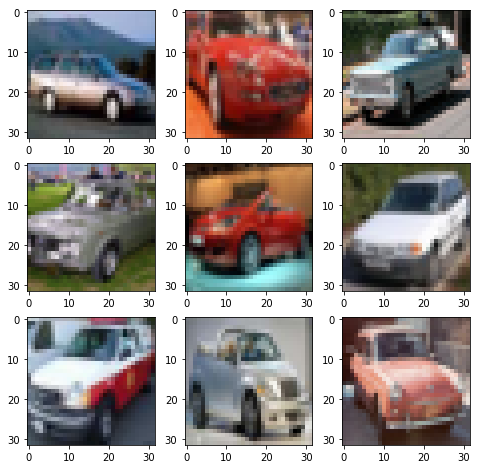

In [11]:
plot_gen(X_train,0,9)
imsave(X_train[:8 * 8, :, :, :], [8, 8],'./' + check_folder(result_dir + '/') + '/' + model_name + 'groupTruth.png')

In [12]:
X_train = X_train/255.
X_test = X_test/255.

In [13]:
X_train[1].shape

(32, 32, 3)

In [14]:
""" Graph Input """
# images
inputs = tf.placeholder(tf.float32, [bs] + image_dims, name='real_images')
print(image_dims)
print(inputs.get_shape())
# noises
z = tf.placeholder(tf.float32, [bs, z_dim], name='z')
print (z.get_shape())

[32, 32, 3]
(64, 32, 32, 3)
(64, 100)


In [15]:
def discriminator( x, is_training=True, reuse=False):
    # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
    # Architecture : (64)4c2s-(128)4c2s_BL-FC1024_BL-FC1_S
    with tf.variable_scope("discriminator", reuse=reuse):

        net = lrelu(conv2d(x, 64, 4, 4, 2, 2, name='d_conv1'))
        net = lrelu(bn(conv2d(net, 128, 4, 4, 2, 2, name='d_conv2'), is_training=is_training, scope='d_bn2'))
        net = lrelu(bn(conv2d(net, 164, 4, 4, 2, 2, name='d_conv3'), is_training=is_training, scope='d_bn3'))
        net = lrelu(bn(conv2d(net, 256, 4, 4, 2, 2, name='d_conv4'), is_training=is_training, scope='d_bn4'))
        net = tf.reshape(net, [batch_size, -1])
        net = lrelu(bn(linear(net, 1024, scope='d_fc3'), is_training=is_training, scope='d_bn5'))
        out_logit = linear(net, 1, scope='d_fc4')
        out = tf.nn.sigmoid(out_logit)

        return out, out_logit, net

In [16]:
def generator( z, is_training=True, reuse=False):
    # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
    # Architecture : FC1024_BR-FC7x7x128_BR-(64)4dc2s_BR-(1)4dc2s_S
    with tf.variable_scope("generator", reuse=reuse):
        net = tf.nn.relu(bn(linear(z, 2046, scope='g_fc1'), is_training=is_training, scope='g_bn1'))
        net = tf.nn.relu(bn(linear(net, 512 * input_height/16 * input_width/16, scope='g_fc2'), is_training=is_training, scope='g_bn2'))
        net = tf.reshape(net, [batch_size, int(input_height/16), int(input_width/16), 512])
        net = tf.nn.relu(
            bn(deconv2d(net, [batch_size, int(input_height/8), int(input_width/8), 256], 4, 4, 2, 2, name='g_dc0'), is_training=is_training,
               scope='g_bn0'))
        net = tf.nn.relu(
            bn(deconv2d(net, [batch_size, int(input_height/4), int(input_width/4), 128], 4, 4, 2, 2, name='g_dc3'), is_training=is_training,
               scope='g_bn3'))
        net = tf.nn.relu(
            bn(deconv2d(net, [batch_size, int(input_height/2), int(input_width/2), 64], 4, 4, 2, 2, name='g_dc4'), is_training=is_training,
               scope='g_bn4'))
        
        out = tf.nn.sigmoid(deconv2d(net, [batch_size, input_height, input_width, 3], 4, 4, 2, 2, name='g_dc5'))
        
#         net = tf.nn.relu(bn(linear(z, 1024, scope='g_fc1'), is_training=is_training, scope='g_bn0'))
#         net = tf.nn.relu(bn(linear(net, 128 * input_height/8 * input_width/8, scope='g_fc2'), is_training=is_training, scope='g_bn0_1'))
#         net = tf.reshape(net, [batch_size, int(input_height/2), int(input_width/2), 64])
#         net = lrelu(bn(deconv2d(net, [batch_size, int(input_height/4), int(input_width/4), 128], 4, 4, 2, 2, name='g_dc1'), is_training=is_training, scope='g_bn1'))
#         net = lrelu(bn(deconv2d(net, [batch_size, int(input_height/2), int(input_width/2), 64], 4, 4, 2, 2, name='g_dc2'), is_training=is_training, scope='g_bn2'))
#         net = lrelu(bn(deconv2d(net, [batch_size, input_height, input_width, 3], 4, 4, 2, 2, name='g_dc3'), is_training=is_training, scope='g_bn3'))
#         out = tf.nn.tanh(net)

#         with tf.variable_scope('g', reuse=reuse):
#             # reshape from inputs
#             with tf.variable_scope('g_reshape'):
                
# #                 matrix = tf.get_variable("Matrix", [z.get_shape()[1], 1024], tf.float32,tf.random_normal_initializer(stddev=0.02))
# #                 bias = tf.get_variable("bias", [1024],
# #                 initializer=tf.constant_initializer(0.0))
# #                 outputs = tf.matmul(z, matrix) + bias, matrix, bias
                
#                 outputs = tf.nn.relu(bn(linear(z, 1024, scope='g_fc1'), is_training=is_training, scope='g_bn1'))
#                 outputs = tf.nn.relu(bn(linear(outputs, 1024 * 2 * 2, scope='g_fc2'), is_training=is_training, scope='g_bn2'))

#                 outputs = tf.reshape(outputs, [-1, 2, 2, 1024])
#                 outputs = tf.nn.relu(tf.layers.batch_normalization(outputs, training=is_training), name='outputs')
#             # deconvolution (transpose of convolution) x 4
#             with tf.variable_scope('g_deconv1'):
#                 w = tf.get_variable('w1', [4,4,256,outputs.get_shape()[-1]],initializer=tf.random_normal_initializer(stddev=0.02))
#                 outputs = tf.nn.conv2d_transpose(outputs, w, [batch_size, int(input_height/8), int(input_width/8), 256], strides=(1, 2, 2, 1), padding='SAME')
#                 biases = tf.get_variable('biases', [outputs.get_shape()[-1]], initializer=tf.constant_initializer(0.0))
#                 outputs = tf.reshape(tf.nn.bias_add(outputs, biases), outputs.get_shape())
#                 outputs = tf.nn.relu(tf.layers.batch_normalization(outputs, training=is_training), name='outputs')
#             with tf.variable_scope('g_deconv2'):
#                 w = tf.get_variable('w2', [4,4,128,outputs.get_shape()[-1]],initializer=tf.random_normal_initializer(stddev=0.02))
#                 outputs = tf.nn.conv2d_transpose(outputs, w, [batch_size, int(input_height/4), int(input_width/4), 128], strides=(1, 2, 2, 1), padding='SAME')
#                 biases = tf.get_variable('biases', [outputs.get_shape()[-1]], initializer=tf.constant_initializer(0.0))
#                 outputs = tf.reshape(tf.nn.bias_add(outputs, biases), outputs.get_shape())
#                 outputs = tf.nn.relu(tf.layers.batch_normalization(outputs, training=is_training), name='outputs')
#             with tf.variable_scope('g_deconv3'):
#                 w = tf.get_variable('w3', [4,4,64,outputs.get_shape()[-1]],initializer=tf.random_normal_initializer(stddev=0.02))
#                 outputs = tf.nn.conv2d_transpose(outputs, w, [batch_size, int(input_height/2), int(input_width/2), 64], strides=(1, 2, 2, 1), padding='SAME')
#                 outputs = tf.nn.relu(tf.layers.batch_normalization(outputs, training=is_training), name='outputs')
#             with tf.variable_scope('g_deconv4'):
#                 w = tf.get_variable('w4', [4,4,3,outputs.get_shape()[-1]],initializer=tf.random_normal_initializer(stddev=0.02))
#                 outputs = tf.nn.conv2d_transpose(outputs, w, [batch_size, input_height, input_width, 3], strides=(1, 2, 2, 1), padding='SAME')
#                 biases = tf.get_variable('biases', [outputs.get_shape()[-1]], initializer=tf.constant_initializer(0.0))
#                 outputs = tf.reshape(tf.nn.bias_add(outputs, biases), outputs.get_shape())
#             # output images
#             with tf.variable_scope('sigmoid'):
#                 out = tf.sigmoid(outputs, name='outputs')
        return out

In [17]:
output = tf.constant(0.1, shape=(batch_size, int(input_height/8), int(input_width/8), 256))
w = tf.get_variable('w17', [4,4,256,1024],initializer=tf.random_normal_initializer(stddev=0.02))
expected_l = tf.nn.conv2d(output, w, strides=(1,2,2,1), padding='SAME')
print (expected_l.get_shape())
# Prints (3, 4, 4, 4)

(64, 2, 2, 1024)


In [18]:
# for test
fake_images = generator(z, is_training=False, reuse=False)
z_sample = np.random.uniform(-1, 1, size=(batch_size, z_dim))
print (z_sample)
with tf.Session(config=tf.ConfigProto(allow_soft_placement=False)) as sess:
    tf.global_variables_initializer().run()
    samples = sess.run(fake_images, feed_dict={z: z_sample})

[[ 0.90096357  0.18042661 -0.9400309  ...,  0.29867908  0.18250404
   0.651678  ]
 [-0.69739877  0.69401932 -0.60430433 ...,  0.82466181  0.91492725
  -0.41998938]
 [ 0.007839   -0.97819654  0.60771664 ...,  0.4947903  -0.49625694
   0.8273137 ]
 ..., 
 [ 0.20389754 -0.94905198 -0.71165288 ...,  0.9805823   0.68363479
  -0.35275257]
 [-0.13059084 -0.28661759 -0.61328016 ..., -0.86673783 -0.04545977
   0.24213122]
 [-0.46215247  0.38863263 -0.95630216 ...,  0.20423479 -0.01384106
  -0.16535881]]


In [19]:
samples.shape

(64, 32, 32, 3)

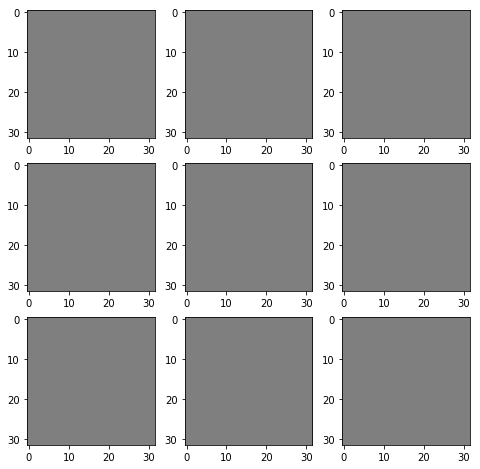

In [20]:
plot_gen(samples,0,9)

In [21]:
# output of D for real images
D_real, D_real_logits, _ = discriminator(inputs, is_training=True, reuse=False)

# output of D for fake images
G = generator(z, is_training=True, reuse=True)
D_fake, D_fake_logits, _ = discriminator(G, is_training=True, reuse=True)

# get loss for discriminator
d_loss_real = - tf.reduce_mean(D_real_logits)
d_loss_fake = tf.reduce_mean(D_fake_logits)

d_loss = d_loss_real + d_loss_fake

# get loss for generator
g_loss = - d_loss_fake

""" Summary """
d_loss_real_sum = tf.summary.scalar("d_loss_real", d_loss_real)
d_loss_fake_sum = tf.summary.scalar("d_loss_fake", d_loss_fake)
d_loss_sum = tf.summary.scalar("d_loss", d_loss)
g_loss_sum = tf.summary.scalar("g_loss", g_loss)

# final summary operations
g_sum = tf.summary.merge([d_loss_fake_sum, g_loss_sum])
d_sum = tf.summary.merge([d_loss_real_sum, d_loss_sum])

In [22]:
# divide trainable variables into a group for D and a group for G
t_vars = tf.trainable_variables()
d_vars = [var for var in t_vars if 'd_' in var.name]
g_vars = [var for var in t_vars if 'g_' in var.name]

In [23]:
g_vars

[<tf.Variable 'generator/g_fc1/Matrix:0' shape=(100, 2046) dtype=float32_ref>,
 <tf.Variable 'generator/g_fc1/bias:0' shape=(2046,) dtype=float32_ref>,
 <tf.Variable 'generator/g_bn1/beta:0' shape=(2046,) dtype=float32_ref>,
 <tf.Variable 'generator/g_bn1/gamma:0' shape=(2046,) dtype=float32_ref>,
 <tf.Variable 'generator/g_fc2/Matrix:0' shape=(2046, 2048) dtype=float32_ref>,
 <tf.Variable 'generator/g_fc2/bias:0' shape=(2048,) dtype=float32_ref>,
 <tf.Variable 'generator/g_bn2/beta:0' shape=(2048,) dtype=float32_ref>,
 <tf.Variable 'generator/g_bn2/gamma:0' shape=(2048,) dtype=float32_ref>,
 <tf.Variable 'generator/g_dc0/w:0' shape=(4, 4, 256, 512) dtype=float32_ref>,
 <tf.Variable 'generator/g_dc0/biases:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'generator/g_bn0/beta:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'generator/g_bn0/gamma:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'generator/g_dc3/w:0' shape=(4, 4, 128, 256) dtype=float32_ref>,
 <tf.Variable 'generator

In [24]:
# optimizers
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    d_optim = tf.train.AdamOptimizer(learning_rate, beta1=beta1) \
              .minimize(d_loss, var_list=d_vars)
    g_optim = tf.train.AdamOptimizer(learning_rate*5, beta1=beta1) \
              .minimize(g_loss, var_list=g_vars)

In [ ]:
# weight clipping this is key to Wassstein GAN
clip_D = [p.assign(tf.clip_by_value(p, -0.01, 0.01)) for p in d_vars]

In [ ]:

with tf.Session(config=tf.ConfigProto(allow_soft_placement=False)) as sess:
        # initialize all variables
    tf.global_variables_initializer().run()

    # summary writer
    writer = tf.summary.FileWriter('./logs/' + '/' + model_name, sess.graph)
    # graph inputs for visualize training results
    sample_z = np.random.uniform(-1, 1, size=(batch_size , z_dim))
    # loop for epoch
    start_time = time.time()
    
    print(start_time)
    start_epoch = 0
    start_batch_id = 0
    counter = 1
    for temp_epoch in range(start_epoch, epoch):

        # get batch data
        for idx in range(start_batch_id, num_batches):
            batch_images = X_train[idx*batch_size:(idx+1)*batch_size]
            batch_z = np.random.uniform(-1, 1, [batch_size, z_dim]).astype(np.float32)
            
            # update D network
            if (counter - 1) % disc_iters == 0:
                _, _, summary_str, dd_loss = sess.run([d_optim, clip_D, d_sum, d_loss], feed_dict={inputs: batch_images, z: batch_z})
                writer.add_summary(summary_str, counter)

            # update G network
            _, summary_str, gg_loss = sess.run([g_optim, g_sum, g_loss], feed_dict={z: batch_z})
            writer.add_summary(summary_str, counter)

            # display training status
            
            print("Epoch: [%2d] [%4d/%4d] time: %4.4f, d_loss: %.8f, g_loss: %.8f" \
                  % (temp_epoch, idx, num_batches, time.time() - start_time, dd_loss, gg_loss))
            
            # save training results for every 300 steps
            if np.mod(counter, 300) == 0:
                samples = sess.run(fake_images, feed_dict={z: sample_z})
                tot_num_samples = min(sample_num, batch_size)
                manifold_h = int(np.floor(np.sqrt(tot_num_samples)))
                manifold_w = int(np.floor(np.sqrt(tot_num_samples)))
                #plot_gen(samples,0,9)
                print (manifold_h)
                print (manifold_w)
                imsave(samples[:manifold_h * manifold_w, :, :, :], [manifold_h, manifold_w],
                            './' + check_folder(result_dir + '/') + '/' + model_name + '_train_{:02d}_{:04d}.png'.format(
                                temp_epoch, idx))
            counter += 1
        # After an epoch, start_batch_id is set to zero
        # non-zero value is only for the first epoch after loading pre-trained model
        start_batch_id = 0


1511601348.6867232
Epoch: [ 0] [   0/  93] time: 0.8401, d_loss: -0.00000405, g_loss: -0.00004330
Epoch: [ 0] [   1/  93] time: 0.9191, d_loss: -0.00000405, g_loss: -0.00008582
Epoch: [ 0] [   2/  93] time: 0.9931, d_loss: -0.00000405, g_loss: -0.00010422
Epoch: [ 0] [   3/  93] time: 1.1538, d_loss: -0.00037968, g_loss: 0.00001950
Epoch: [ 0] [   4/  93] time: 1.2229, d_loss: -0.00037968, g_loss: -0.00010434
Epoch: [ 0] [   5/  93] time: 1.2907, d_loss: -0.00037968, g_loss: -0.00026077
Epoch: [ 0] [   6/  93] time: 1.4300, d_loss: -0.00072445, g_loss: -0.00047033
Epoch: [ 0] [   7/  93] time: 1.4957, d_loss: -0.00072445, g_loss: -0.00188099
Epoch: [ 0] [   8/  93] time: 1.5576, d_loss: -0.00072445, g_loss: -0.00346482
Epoch: [ 0] [   9/  93] time: 1.6881, d_loss: 0.00092043, g_loss: -0.00089488
Epoch: [ 0] [  10/  93] time: 1.7565, d_loss: 0.00092043, g_loss: -0.00125093
Epoch: [ 0] [  11/  93] time: 1.8182, d_loss: 0.00092043, g_loss: -0.00203264
Epoch: [ 0] [  12/  93] time: 1.9515,